# MPS using the deesse wrapper - multivariate simulations (I)

## Main points addressed:
- bivariate deesse simulation (categorical and continuous variables), stationary case

## Import what is required

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os

# import package 'geone'
import geone as gn

In [2]:
# Show version of python and version of geone
import sys 
print(sys.version_info)
print('geone version: ' + gn.__version__)

sys.version_info(major=3, minor=11, micro=5, releaselevel='final', serial=0)
geone version: 1.2.4


## Training image (TI)

The training image (TI) is read from the file `ti_2var.txt`. This is a bivariate TI: the first variable is categorical (3 facies) and the second one is continuous.

**Note:** to clarify the terminology, we say that we work with a *single* TI having *two* variables (or properties). The concept of *multivariate* simulation / TI consists in considering *one (single)* grid with *several* variables attached to each cell.

In [3]:
# Read file 
data_dir = 'data'
filename = os.path.join(data_dir, 'ti_2var.txt')
ti = gn.img.readImageTxt(filename)

## Plot both variables of the image using the function `geone.imgplot.drawImage2D`

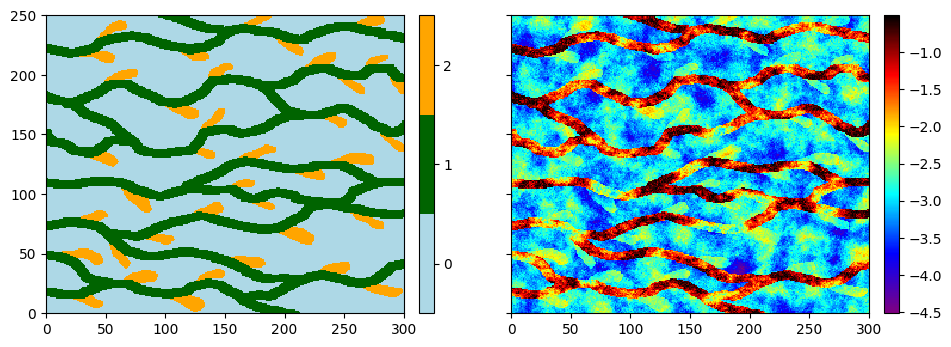

In [4]:
# Color settings - 1st variable (index 0)
facies = ti.get_unique_one_var(0) # facies = [0., 1., 2.], values taken by the 1st variable
facies_col = ['lightblue', 'darkgreen', 'orange'] # color for facies

# Color settings - 2nd variable (index 1)
vcont_min = ti.vmin()[1] # min TI value of the 2nd variable
vcont_max = ti.vmax()[1] # max TI value of the 2nd variable
vcont_cmap = gn.customcolors.cmap2 # choose a color map for the 2nd variable

# Display
plt.subplots(1, 2, figsize=(11,5), sharey=True) # 1 x 2 sub-plots

plt.subplot(1,2,1)
gn.imgplot.drawImage2D(ti, iv=0, categ=True, categVal=facies, categCol=facies_col)

plt.subplot(1,2,2)
gn.imgplot.drawImage2D(ti, iv=1, cmap=vcont_cmap, vmin=vcont_min, vmax=vcont_max)

plt.show()

## Simulation grid
Define the simulation grid (number of cells in each direction, cell unit, origin).

In [5]:
nx, ny, nz = 100, 100, 1         # number of cells
sx, sy, sz = ti.sx, ti.sy, ti.sz # cell unit
ox, oy, oz = 0.0, 0.0, 0.0       # origin (corner of the "first" grid cell)

## Hard data
Define some hard data (point set). Note that some points can have only one variable uninformed (`numpy.nan`).

In [6]:
npt = 5 # number of points
nv = 5   # number of variables including x, y, z coordinates
varname = ['x', 'y', 'z', 'facies', 'vcont'] # list of variable names
v = np.array([
    [ 10.5,  40.5, 0.5,  1,      -1.2], # x, y, z, facies, vcont: 1st point
    [ 50.5,  35.5, 0.5,  np.nan, -0.8], # ...
    [ 90.5,  48.5, 0.5,  1,      np.nan],
    [ 75.5,  50.5, 0.5,  0,      -4.0],
    [ 20.5,  80.5, 0.5,  2,      -2.0]    
    ]).T # variable values: (nv, npt)-array
hd = gn.img.PointSet(npt=npt, nv=nv, varname=varname, val=v)

Plot the hard data points in the simulation grid.

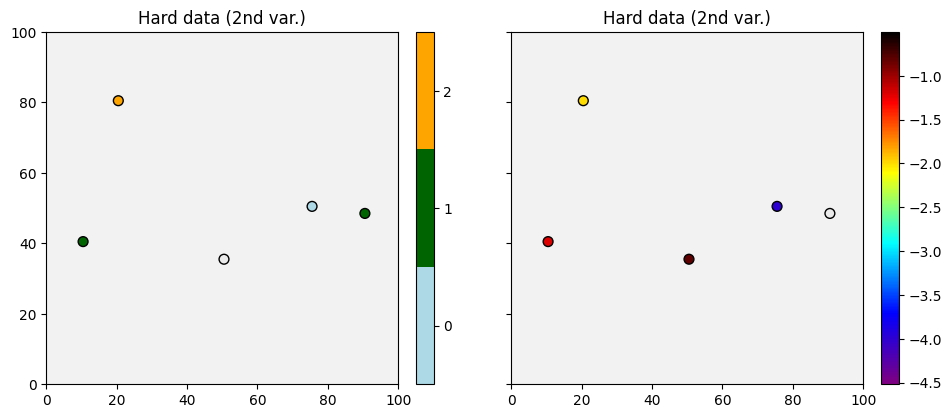

In [7]:
# Get the colors for hard data points according to their values and color settings used for the TI
hd_facies_col = gn.imgplot.get_colors_from_values(hd.val[3], categ=True, categVal=facies, categCol=facies_col)
hd_vcont_col = gn.imgplot.get_colors_from_values(hd.val[4], cmap=vcont_cmap, vmin=vcont_min, vmax=vcont_max)

# Set an image with simulation grid geometry defined above, and no variable
im_empty = gn.img.Img(nx, ny, nz, sx, sy, sz, ox, oy, oz, nv=0)

# Plot
plt.subplots(1, 2, figsize=(11,5), sharey=True) # 1 x 2 sub-plots

plt.subplot(1,2,1)
# 1st variable (facies); plot empty simulation grid and specify colors
gn.imgplot.drawImage2D(im_empty, categ=True, categVal=facies, categCol=facies_col)
# Add hard data points
plt.scatter(hd.x(), hd.y(), marker='o', s=50, color=hd_facies_col, edgecolors='black', linewidths=1)
plt.title('Hard data (2nd var.)')

plt.subplot(1,2,2)
# 1st variable (facies); plot empty simulation grid and specify colors
gn.imgplot.drawImage2D(im_empty, cmap=vcont_cmap, vmin=vcont_min, vmax=vcont_max)
# Add hard data points
plt.scatter(hd.x(), hd.y(), marker='o', s=50, color=hd_vcont_col, edgecolors='black', linewidths=1)
plt.title('Hard data (2nd var.)')

plt.show()

Some conditioning data points are uninformed for the 1st or 2nd variable (in gray in the plot above).

Get the index of conditioning data points where the value is known, for each variable.

In [8]:
hd_facies_index = np.where(~np.isnan(hd.val[3]))[0]
hd_vcont_index = np.where(~np.isnan(hd.val[4]))[0]

## Fill the input structure for deesse and launch deesse
**Reminder:** variable names for the hard data (in `hd.varname`) and for the simulated variables (`varname` below) should correspond (otherwise, the hard data will be ignored).

In [9]:
nreal = 20
deesse_input = gn.deesseinterface.DeesseInput(
    nx=nx, ny=ny, nz=nz,
    sx=sx, sy=sy, sz=sz,
    ox=ox, oy=oy, oz=oz,
    nv=2, varname=['facies', 'vcont'], # number of variable(s), name of the variable(s)
    TI=ti,
    dataPointSet=hd,
    distanceType=['categorical', 'continuous'], # distance type for each variable
    nneighboringNode=[12, 12],      # max. number of neighbors (for the patterns), for each variable
    distanceThreshold=[.02,.02],    # acceptation threshold (for distance between patterns), for each variable
    maxScanFraction=0.1,
    npostProcessingPathMax=1,
    seed=444,
    nrealization=nreal)

# Run deesse
t1 = time.time() # start time
deesse_output = gn.deesseinterface.deesseRun(deesse_input)
t2 = time.time() # end time
print(f'Elapsed time: {t2-t1:.2g} sec')

DeeSse running... [VERSION 3.2 / BUILD NUMBER 20230914 / OpenMP 19 thread(s)]
DeeSse run complete
Elapsed time: 29 sec


## Retrieve the results (and display)

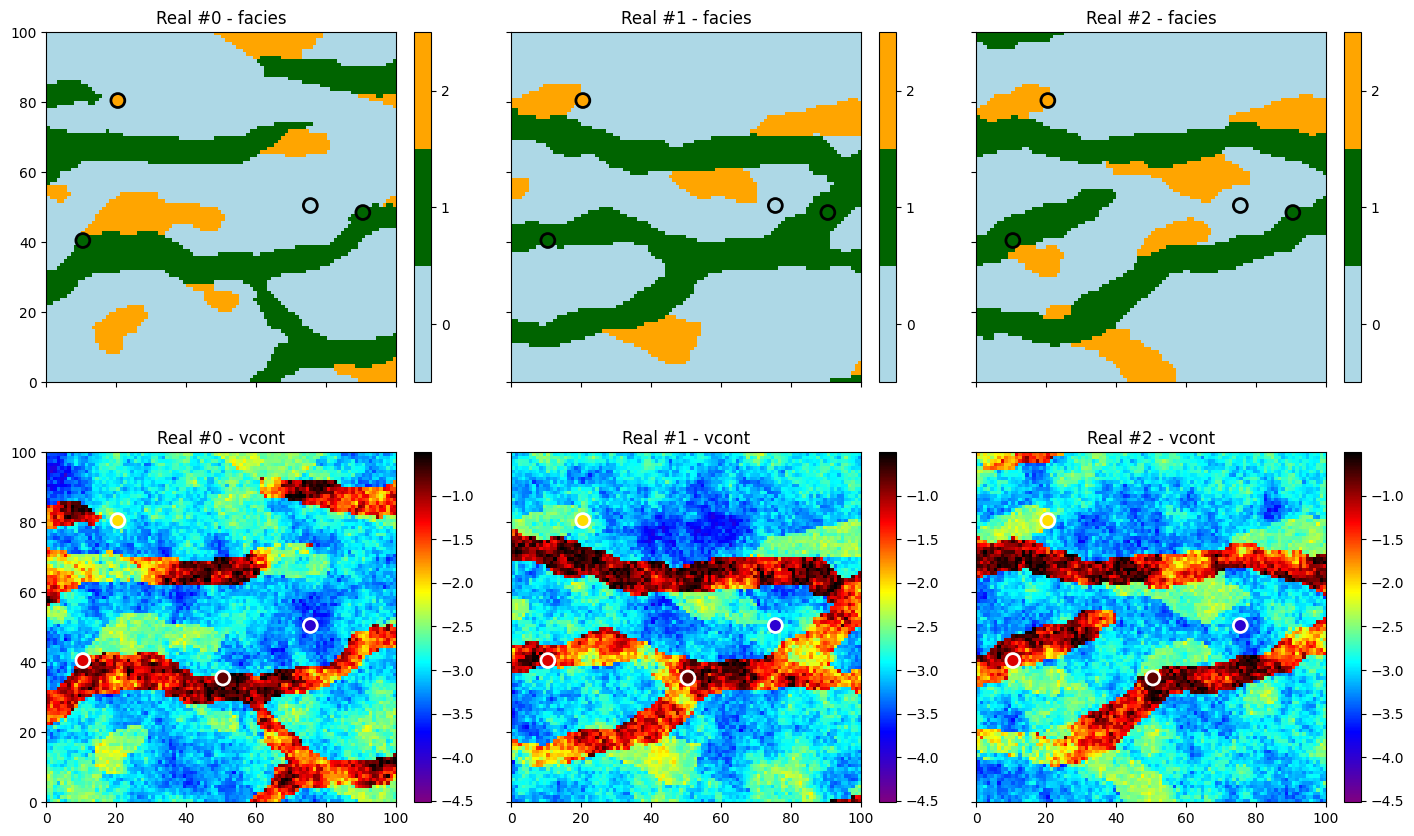

In [10]:
# Retrieve the realizations
sim = deesse_output['sim']

# Display
plt.subplots(2, 3, figsize=(17,10), sharex=True, sharey=True) # 2 x 3 sub-plots

# ... plot the 1st variable of the three first realizations
iv = 0
for i in range(3):
    plt.subplot(2, 3, i+1) # select next sub-plot
    gn.imgplot.drawImage2D(sim[i], iv=iv, categ=True, categVal=facies, categCol=facies_col, 
                           title=f'Real #{i} - {deesse_input.varname[iv]}')
    plt.scatter(hd.x()[hd_facies_index], hd.y()[hd_facies_index], marker='o', s=100, 
                color=hd_facies_col[hd_facies_index], edgecolors='black', linewidths=2) # add hard data points
                                                                                        # (known values only)

# ... plot the 2nd variable of the three first realizations
iv = 1
for i in range(3):
    plt.subplot(2, 3, i+4) # select next sub-plot
    gn.imgplot.drawImage2D(sim[i], iv=iv, cmap=vcont_cmap, vmin=vcont_min, vmax=vcont_max, 
                           title=f'Real #{i} - {deesse_input.varname[iv]}')
    plt.scatter(hd.x()[hd_vcont_index], hd.y()[hd_vcont_index], marker='o', s=100, 
                color=hd_vcont_col[hd_vcont_index], edgecolors='white', linewidths=2) # add hard data points
                                                                                      # (known values only)

plt.show()

## Do some statistics on the realizations

In [11]:
# Do statistics for the 1st variable over all the realizations
# ... gather the nreal realizations of 1st variable into one image
all_sim0 = gn.img.gatherImages(sim, varInd=0) # all_sim is one image with nreal variables (all 1st variables)
# ... compute the pixel-wise proportion for the given categories
all_sim0_stats = gn.img.imageCategProp(all_sim0, facies)

# Do statistics for the 2nd variable over all the realizations
# ... gather the nreal realizations of 2nd variable into one image
all_sim1 = gn.img.gatherImages(sim, varInd=1) # all_sim is one image with nreal variables (all 2nd variables)
# ... compute the pixel-wise mean and standard deviation
all_sim1_mean = gn.img.imageContStat(all_sim1, op='mean')
all_sim1_std = gn.img.imageContStat(all_sim1, op='std')

In [12]:
# Equivalently:
all_sim0_stats2 = gn.img.imageListCategProp(sim, facies, ind=0)
print("Same result (facies prop.) ?", gn.img.isImageEqual(all_sim0_stats, all_sim0_stats2)) # should be True

all_sim1_mean2 = gn.img.imageListContStat(sim, op='mean', ind=1)
print("Same result (vcont mean) ?", gn.img.isImageEqual(all_sim1_mean, all_sim1_mean2)) # should be True
all_sim1_std2 = gn.img.imageListContStat(sim, op='std', ind=1)
print("Same result (vcont mean) ?", gn.img.isImageEqual(all_sim1_std, all_sim1_std2)) # should be True

Same result (facies prop.) ? True
Same result (vcont mean) ? True
Same result (vcont mean) ? True


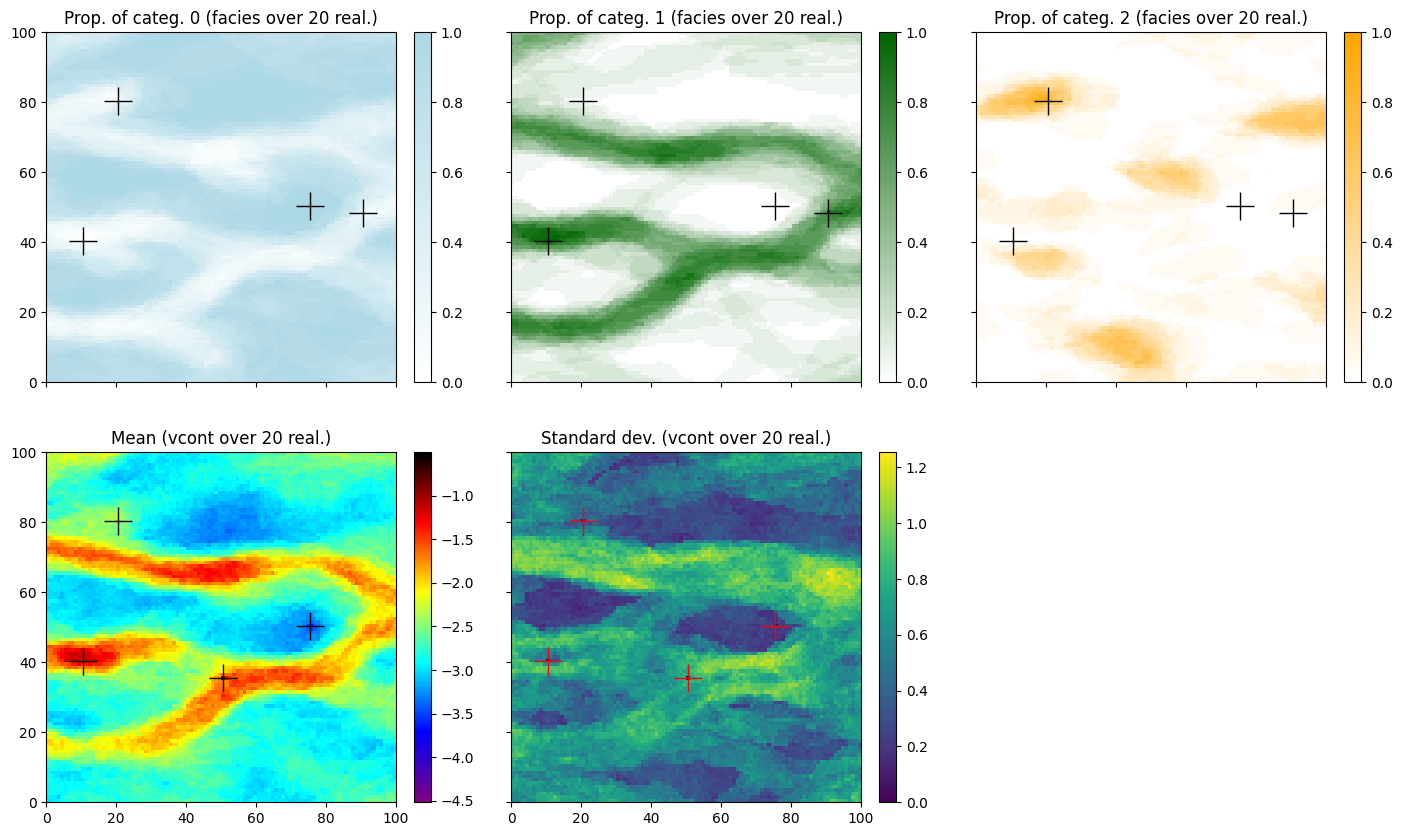

In [13]:
# Display
prop_col=facies_col # colors for the proportion maps
prop_cmap = [gn.customcolors.custom_cmap(['white', c]) for c in prop_col]

# proportion map - facies (1st var.)
plt.subplots(2, 3, figsize=(17,10), sharex=True, sharey=True) # 2 x 3 sub-plots
for i in range(3):
    plt.subplot(2, 3, i+1) # select next sub-plot
    gn.imgplot.drawImage2D(all_sim0_stats, iv=i, cmap=prop_cmap[i],
        title=f'Prop. of categ. {i} ({deesse_input.varname[0]} over {nreal} real.)')
    # add hard data points (with known values)
    plt.plot(hd.x()[hd_facies_index], hd.y()[hd_facies_index], '+', markersize=20, c='black') 
    

# mean map - vcont (2nd var.)
plt.subplot(2,3,4) # select next sub-plot
gn.imgplot.drawImage2D(all_sim1_mean, cmap=vcont_cmap, vmin=vcont_min, vmax=vcont_max,
                       title=f'Mean ({deesse_input.varname[1]} over {nreal} real.)')
# add hard data points (with known values)
plt.plot(hd.x()[hd_vcont_index], hd.y()[hd_vcont_index], '+', markersize=20, c='k')

# standard deviation map - vcont (2nd var.)
plt.subplot(2,3,5) # select 2nd sub-plot
gn.imgplot.drawImage2D(all_sim1_std, 
                       title=f'Standard dev. ({deesse_input.varname[1]} over {nreal} real.)')
# add hard data points (with known values)
plt.plot(hd.x()[hd_vcont_index], hd.y()[hd_vcont_index], '+', markersize=20, c='red')


plt.subplot(2,3,6) # select 2nd sub-plot
plt.axis('off') # no plot

plt.show()

## Simulations using pyramids
Enabling pyramids implies multi-resolution simulations, which can help to better reproduce the spatial structures.

In [14]:
# Deesse input
#   - with 2 additional levels (npyramidLevel=2) 
#     and a reduction factor of 2 along x and y axes between the original image 
#     and the 1st pyramid level and between the 1st pyramid level to the second one 
#     (kx=[2, 2], ky=[2, 2], kz=[0, 0]: do not apply reduction along z axis)
pyrGenParams = gn.deesseinterface.PyramidGeneralParameters(
    npyramidLevel=2, 
    kx=[2, 2], ky=[2, 2], kz=[0, 0]
)
pyrParams = [
    gn.deesseinterface.PyramidParameters(nlevel=2, pyramidType='categorical_auto'), # for 1st variable
    gn.deesseinterface.PyramidParameters(nlevel=2, pyramidType='continuous')        # for 2nd variable
]

nreal = 20
deesse_input = gn.deesseinterface.DeesseInput(
    nx=nx, ny=ny, nz=nz,
    sx=sx, sy=sy, sz=sz,
    ox=ox, oy=oy, oz=oz,
    nv=2, varname=['facies', 'vcont'], # number of variable(s), name of the variable(s)
    TI=ti,
    dataPointSet=hd,
    distanceType=['categorical', 'continuous'], # distance type for each variable
    nneighboringNode=[12, 12],      # max. number of neighbors (for the patterns), for each variable
    distanceThreshold=[.02,.02],    # acceptation threshold (for distance between patterns), for each variable
    maxScanFraction=0.1,
    pyramidGeneralParameters=pyrGenParams, # pyramid general parameters
    pyramidParameters=pyrParams,           # pyramid parameters for each variable
    npostProcessingPathMax=1,
    seed=444,
    nrealization=nreal)

# Run deesse
t1 = time.time() # start time
deesse_output = gn.deesseinterface.deesseRun(deesse_input)
t2 = time.time() # end time
print(f'Elapsed time: {t2-t1:.2g} sec')

DeeSse running... [VERSION 3.2 / BUILD NUMBER 20230914 / OpenMP 19 thread(s)]
DeeSse run complete
Elapsed time: 30 sec


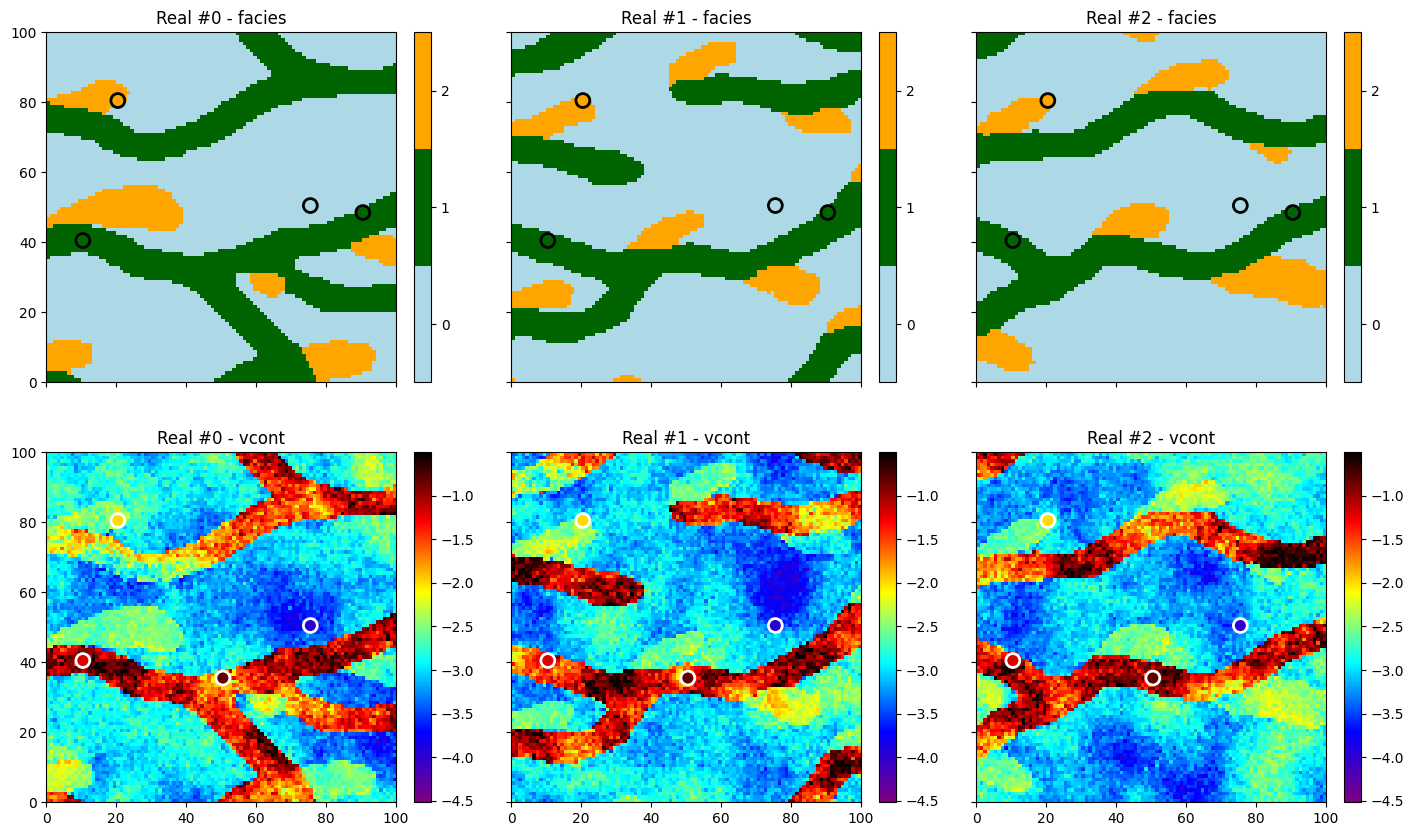

In [15]:
# Retrieve the realizations
sim = deesse_output['sim']

# Display
plt.subplots(2, 3, figsize=(17,10), sharex=True, sharey=True) # 2 x 3 sub-plots

# ... plot the 1st variable of the three first realizations
iv = 0
for i in range(3):
    plt.subplot(2, 3, i+1) # select next sub-plot
    gn.imgplot.drawImage2D(sim[i], iv=iv, categ=True, categVal=facies, categCol=facies_col, 
                           title=f'Real #{i} - {deesse_input.varname[iv]}')
    plt.scatter(hd.x()[hd_facies_index], hd.y()[hd_facies_index], marker='o', s=100, 
                color=hd_facies_col[hd_facies_index], edgecolors='black', linewidths=2) # add hard data points
                                                                                        # (known values only)

# ... plot the 2nd variable of the three first realizations
iv = 1
for i in range(3):
    plt.subplot(2, 3, i+4) # select next sub-plot
    gn.imgplot.drawImage2D(sim[i], iv=iv, cmap=vcont_cmap, vmin=vcont_min, vmax=vcont_max, 
                           title=f'Real #{i} - {deesse_input.varname[iv]}')
    plt.scatter(hd.x()[hd_vcont_index], hd.y()[hd_vcont_index], marker='o', s=100, 
                color=hd_vcont_col[hd_vcont_index], edgecolors='white', linewidths=2) # add hard data points
                                                                                      # (known values only)

plt.show()

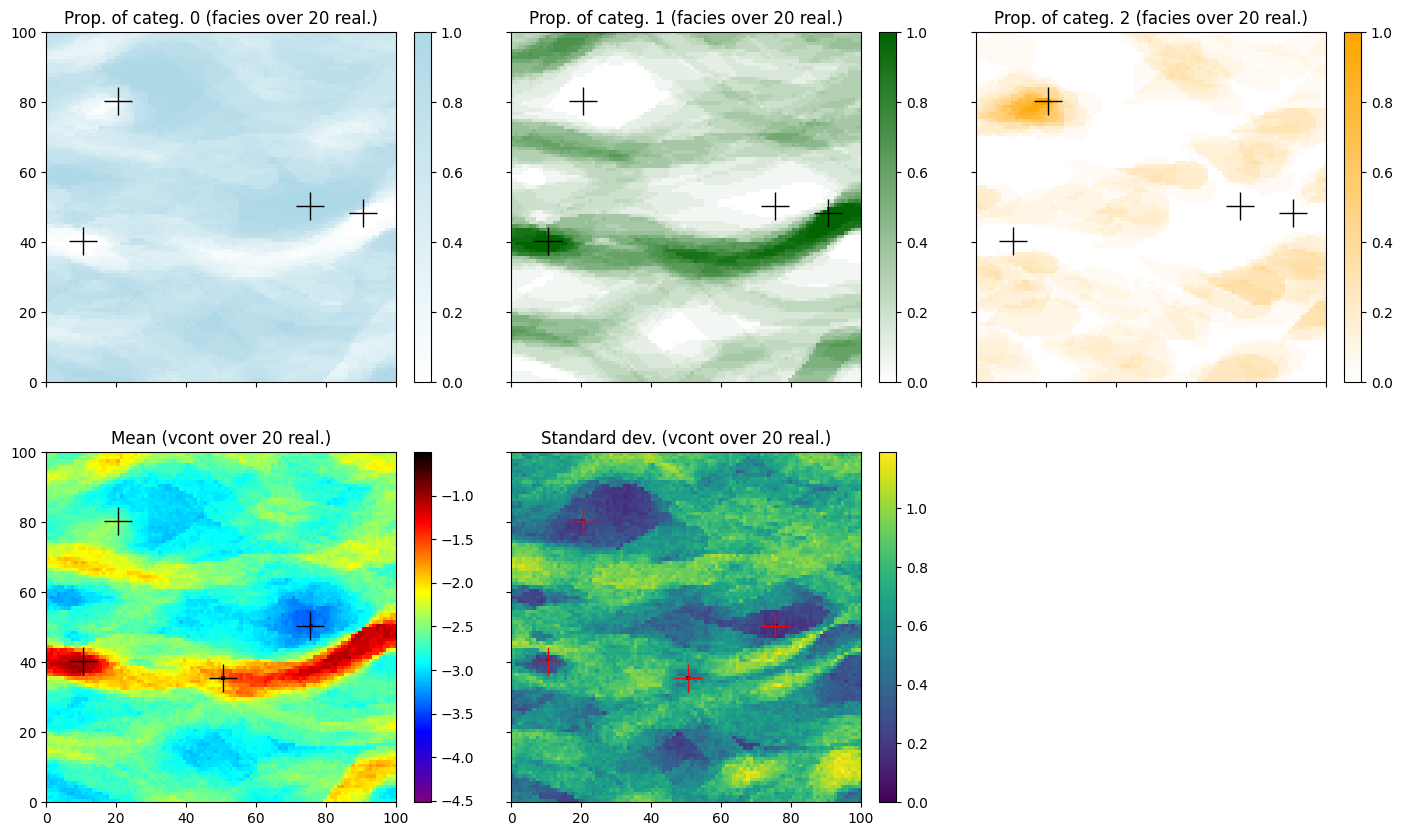

In [16]:
# Do statistics for the 1st variable over all the realizations
all_sim0_stats = gn.img.imageListCategProp(sim, facies, ind=0)

# Do statistics for the 2nd variable over all the realizations
all_sim1_mean = gn.img.imageListContStat(sim, op='mean', ind=1)
all_sim1_std = gn.img.imageListContStat(sim, op='std', ind=1)

# Display
#prop_col=facies_col # colors for the proportion maps
#prop_cmap = [gn.customcolors.custom_cmap(['white', c]) for c in prop_col]

# proportion map - facies (1st var.)
plt.subplots(2, 3, figsize=(17,10), sharex=True, sharey=True) # 2 x 3 sub-plots
for i in range(3):
    plt.subplot(2, 3, i+1) # select next sub-plot
    gn.imgplot.drawImage2D(all_sim0_stats, iv=i, cmap=prop_cmap[i],
        title=f'Prop. of categ. {i} ({deesse_input.varname[0]} over {nreal} real.)')
    # add hard data points (with known values)
    plt.plot(hd.x()[hd_facies_index], hd.y()[hd_facies_index], '+', markersize=20, c='black') 
    

# mean map - vcont (2nd var.)
plt.subplot(2,3,4) # select next sub-plot
gn.imgplot.drawImage2D(all_sim1_mean, cmap=vcont_cmap, vmin=vcont_min, vmax=vcont_max,
                       title=f'Mean ({deesse_input.varname[1]} over {nreal} real.)')
# add hard data points (with known values)
plt.plot(hd.x()[hd_vcont_index], hd.y()[hd_vcont_index], '+', markersize=20, c='k')

# standard deviation map - vcont (2nd var.)
plt.subplot(2,3,5) # select 2nd sub-plot
gn.imgplot.drawImage2D(all_sim1_std, 
                       title=f'Standard dev. ({deesse_input.varname[1]} over {nreal} real.)')
# add hard data points (with known values)
plt.plot(hd.x()[hd_vcont_index], hd.y()[hd_vcont_index], '+', markersize=20, c='red')


plt.subplot(2,3,6) # select 2nd sub-plot
plt.axis('off') # no plot

plt.show()